In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
import plotly.graph_objects as go
import pickle as pkl
from xgboost import XGBClassifier, plot_importance

In [3]:
nvd = pd.read_csv('..\\raw_data\\NVDA.csv')
mrvl = pd.read_csv('..\\raw_data\\MRVL.csv')
inod = pd.read_csv('..\\raw_data\\INOD.csv')

nvd.name = 'NVIDIA'
mrvl.name = 'Marvell'  
inod.name = 'Innodata'

def checkdata(df):
    #print(f"{df.name} Information:")
    #print(df.head())
    #print(df.info())
    #print(df.describe())
    #print(df.isnull().sum())
    #print(df.duplicated().sum())
    print(df.columns)
    #print(df.shape)


In [4]:
inod['stock'] = 'INOD'
mrvl['stock'] = 'MRVL'
nvd['stock'] = 'NVDA'

failed_combined_df = pd.concat([inod, mrvl, nvd], ignore_index=True)

print(checkdata(nvd))

print(checkdata(mrvl)) 

print(checkdata(inod))

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'stock'], dtype='object')
None
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'stock'], dtype='object')
None
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'stock'], dtype='object')
None


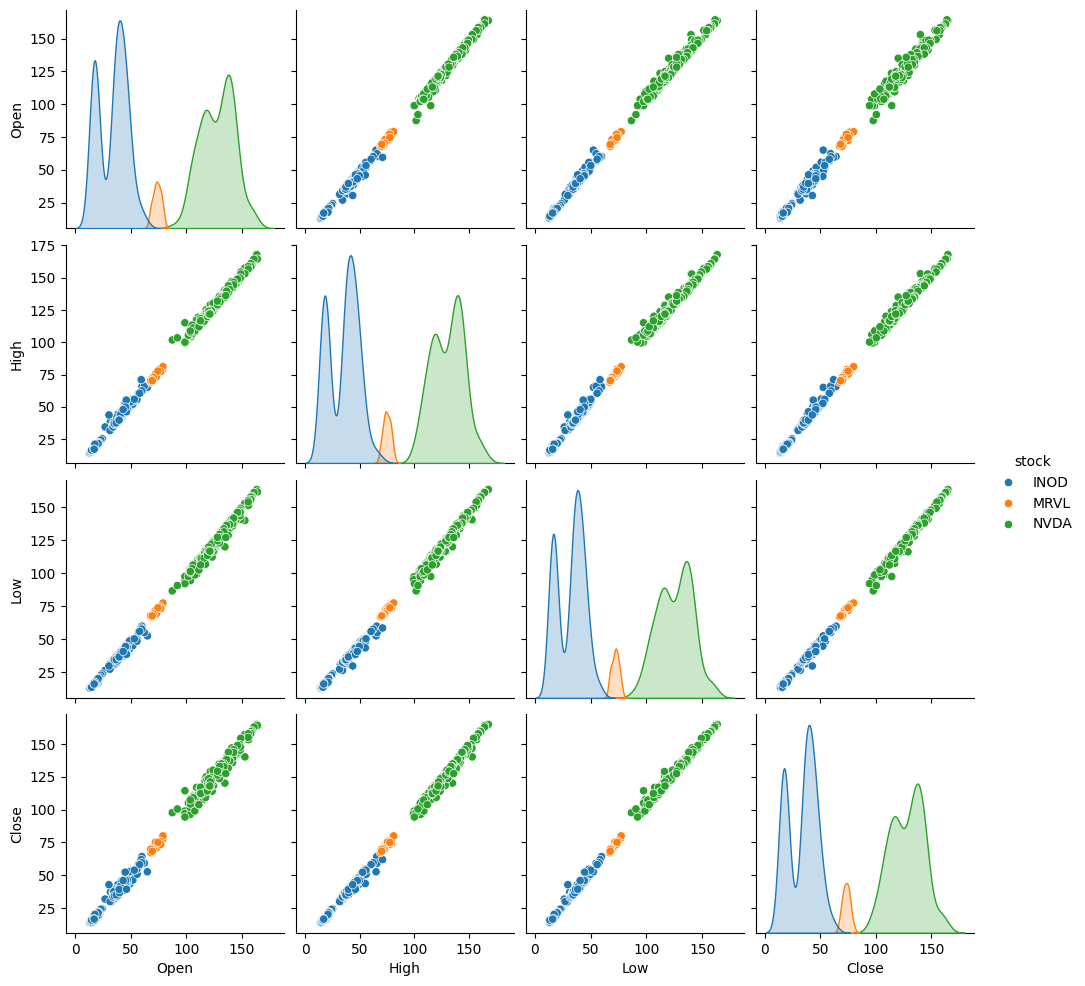

In [5]:
sns.pairplot(failed_combined_df, hue='stock', diag_kind='kde')

In [6]:
#print(inod.dtypes)
#print(mrvl.dtypes)
#print(nvd.dtypes)

nvd.head()

def volume_converter(df):
    """
    Convert columns with commas to float.
    """
    df['Volume'] = (
    df['Volume']
    .str.replace(',', '', regex=False)
    .astype(int)
)
    return df

nvd = volume_converter(nvd)
mrvl = volume_converter(mrvl)
inod = volume_converter(inod)


In [7]:
nvd["Date"] = pd.to_datetime(nvd["Date"], dayfirst=False)
inod["Date"] = pd.to_datetime(inod["Date"], dayfirst=False)
mrvl["Date"] = pd.to_datetime(mrvl["Date"], dayfirst=False)
nvd.head()

,Date,Open,High,Low,Close,Volume,stock
0,2025-07-11,163.72,167.89,163.47,164.92,193633297,NVDA
1,2025-07-10,164.32,164.50,161.61,164.10,167704094,NVDA
2,2025-07-09,161.22,164.42,161.16,162.88,183656406,NVDA
3,2025-07-08,159.33,160.22,158.39,160.00,138132984,NVDA
4,2025-07-07,158.20,159.31,157.34,158.24,140139016,NVDA


In [8]:
inod['open_close_diff'] = inod['Open'] - inod['Close']
mrvl['open_close_diff'] = mrvl['Open'] - mrvl['Close']
nvd['open_close_diff'] = nvd['Open'] - nvd['Close']

# open_close_diff_pct calculates the percentage difference between Open and Close prices relative to Open price
inod['open_close_diff_pct'] = (inod['Open'] - inod['Close']) / inod['Open']
mrvl['open_close_diff_pct'] = (mrvl['Open'] - mrvl['Close']) / mrvl['Open']
nvd['open_close_diff_pct'] = (nvd['Open'] - nvd['Close']) / nvd['Open']


# high_low_diff_pct calculates the percentage difference between High and Low prices relative to Open price & Close price
inod['high_low_diff'] = inod['High'] - inod['Low']
inod['high_low_diff_pct_frm_open'] = (inod['High'] - inod['Low']) / inod['Open']
inod['high_low_diff_pct_frm_close'] = (inod['High'] - inod['Low']) / inod['Close']
mrvl['high_low_diff'] = mrvl['High'] - mrvl['Low'] 
mrvl['high_low_diff_pct_frm_open'] = (mrvl['High'] - mrvl['Low']) / mrvl['Open']
mrvl['high_low_diff_pct_frm_close'] = (mrvl['High'] - mrvl['Low']) / mrvl['Close']
nvd['high_low_diff'] = nvd['High'] - nvd['Low']
nvd['high_low_diff_pct_frm_open'] = (nvd['High'] - nvd['Low']) / nvd['Open']
nvd['high_low_diff_pct_frm_close'] = (nvd['High'] - nvd['Low']) / nvd['Close']

### the Open price is the benchmark for understanding the stock's volatility & correlation with each other.

inod['volume_diff_frm_avg'] = (inod['Volume'] - inod['Volume'].mean())
mrvl['volume_diff_frm_avg'] = (mrvl['Volume'] - mrvl['Volume'].mean())
nvd['volume_diff_frm_avg'] = (nvd['Volume'] - nvd['Volume'].mean())

inod['volume_diff_frm_avg_pct'] = (inod['Volume'] - inod['Volume'].mean()) / inod['Volume'].mean()
mrvl['volume_diff_frm_avg_pct'] = (mrvl['Volume'] - mrvl['Volume'].mean()) / mrvl['Volume'].mean()
nvd['volume_diff_frm_avg_pct'] = (nvd['Volume'] - nvd['Volume'].mean()) / nvd['Volume'].mean()

desired_order = [
    'Date',

    # Price Features
    'Open',
    'Close',
    'open_close_diff',
    'open_close_diff_pct',

    # High–Low Features
    'High',
    'Low',
    'high_low_diff',
    'high_low_diff_pct_frm_open',
    'high_low_diff_pct_frm_close',

    # Volume Features
    'Volume',
    'volume_diff_frm_avg',
    'volume_diff_frm_avg_pct',

    # Identifier
    'stock'
]


inod = inod[desired_order]
mrvl = mrvl[desired_order]
nvd = nvd[desired_order]

print(inod.columns)
print(mrvl.columns)
print(nvd.columns)

Index(['Date', 'Open', 'Close', 'open_close_diff', 'open_close_diff_pct',
       'High', 'Low', 'high_low_diff', 'high_low_diff_pct_frm_open',
       'high_low_diff_pct_frm_close', 'Volume', 'volume_diff_frm_avg',
       'volume_diff_frm_avg_pct', 'stock'],
      dtype='object')
Index(['Date', 'Open', 'Close', 'open_close_diff', 'open_close_diff_pct',
       'High', 'Low', 'high_low_diff', 'high_low_diff_pct_frm_open',
       'high_low_diff_pct_frm_close', 'Volume', 'volume_diff_frm_avg',
       'volume_diff_frm_avg_pct', 'stock'],
      dtype='object')
Index(['Date', 'Open', 'Close', 'open_close_diff', 'open_close_diff_pct',
       'High', 'Low', 'high_low_diff', 'high_low_diff_pct_frm_open',
       'high_low_diff_pct_frm_close', 'Volume', 'volume_diff_frm_avg',
       'volume_diff_frm_avg_pct', 'stock'],
      dtype='object')


In [9]:
print(inod.dtypes)
print(mrvl.dtypes)
print(nvd.dtypes)


Date                           datetime64[ns]
Open                                  float64
Close                                 float64
open_close_diff                       float64
open_close_diff_pct                   float64
High                                  float64
Low                                   float64
high_low_diff                         float64
high_low_diff_pct_frm_open            float64
high_low_diff_pct_frm_close           float64
Volume                                  int64
volume_diff_frm_avg                   float64
volume_diff_frm_avg_pct               float64
stock                                  object
dtype: object
Date                           datetime64[ns]
Open                                  float64
Close                                 float64
open_close_diff                       float64
open_close_diff_pct                   float64
High                                  float64
Low                                   float64
high_low_diff       

In [10]:
inod.head()
mrvl.head()
nvd.head()

,Date,Open,Close,open_close_diff,open_close_diff_pct,High,Low,high_low_diff,high_low_diff_pct_frm_open,high_low_diff_pct_frm_close,Volume,volume_diff_frm_avg,volume_diff_frm_avg_pct,stock
0,2025-07-11,163.72,164.92,-1.20,-0.007330,167.89,163.47,4.42,0.026997,0.026801,193633297,-7.298275e+07,-0.273737,NVDA
1,2025-07-10,164.32,164.10,0.22,0.001339,164.50,161.61,2.89,0.017588,0.017611,167704094,-9.891196e+07,-0.370990,NVDA
2,2025-07-09,161.22,162.88,-1.66,-0.010296,164.42,161.16,3.26,0.020221,0.020015,183656406,-8.295964e+07,-0.311158,NVDA
3,2025-07-08,159.33,160.00,-0.67,-0.004205,160.22,158.39,1.83,0.011486,0.011438,138132984,-1.284831e+08,-0.481903,NVDA
4,2025-07-07,158.20,158.24,-0.04,-0.000253,159.31,157.34,1.97,0.012453,0.012449,140139016,-1.264770e+08,-0.474379,NVDA


In [11]:
def prefix_columns(df, stock_code):
    df = df.copy()
    df = df.drop(columns=['stock'])  # remove redundant stock column
    df.columns = [f"{stock_code}_{col}" if col != 'Date' else 'Date' for col in df.columns]
    return df

inod_prefixed = prefix_columns(inod, 'INOD')
mrvl_prefixed = prefix_columns(mrvl, 'MRVL')
nvd_prefixed = prefix_columns(nvd, 'NVDA')

combined_df = (
    inod_prefixed
    .merge(mrvl_prefixed, on='Date', how='outer')
    .merge(nvd_prefixed, on='Date', how='outer')
)

combined_df.head(40)
combined_df['Date'] = pd.to_datetime(combined_df['Date'], dayfirst=True)

In [12]:
combined_df.columns

Index(['Date', 'INOD_Open', 'INOD_Close', 'INOD_open_close_diff',
       'INOD_open_close_diff_pct', 'INOD_High', 'INOD_Low',
       'INOD_high_low_diff', 'INOD_high_low_diff_pct_frm_open',
       'INOD_high_low_diff_pct_frm_close', 'INOD_Volume',
       'INOD_volume_diff_frm_avg', 'INOD_volume_diff_frm_avg_pct', 'MRVL_Open',
       'MRVL_Close', 'MRVL_open_close_diff', 'MRVL_open_close_diff_pct',
       'MRVL_High', 'MRVL_Low', 'MRVL_high_low_diff',
       'MRVL_high_low_diff_pct_frm_open', 'MRVL_high_low_diff_pct_frm_close',
       'MRVL_Volume', 'MRVL_volume_diff_frm_avg',
       'MRVL_volume_diff_frm_avg_pct', 'NVDA_Open', 'NVDA_Close',
       'NVDA_open_close_diff', 'NVDA_open_close_diff_pct', 'NVDA_High',
       'NVDA_Low', 'NVDA_high_low_diff', 'NVDA_high_low_diff_pct_frm_open',
       'NVDA_high_low_diff_pct_frm_close', 'NVDA_Volume',
       'NVDA_volume_diff_frm_avg', 'NVDA_volume_diff_frm_avg_pct'],
      dtype='object')

In [13]:
selected_data = combined_df[['Date','INOD_open_close_diff_pct', 'INOD_high_low_diff_pct_frm_open','NVDA_open_close_diff_pct','NVDA_volume_diff_frm_avg_pct', 'NVDA_Close', 
                             'NVDA_high_low_diff_pct_frm_open']]

start_date = pd.to_datetime("07/11/2024", dayfirst=True)
selected_data.dtypes

selected_data = selected_data[selected_data["Date"] >= start_date]

selected_data = selected_data.sort_values(by='Date', ascending=True).reset_index(drop=True)
selected_data.head()

,Date,INOD_open_close_diff_pct,INOD_high_low_diff_pct_frm_open,NVDA_open_close_diff_pct,NVDA_volume_diff_frm_avg_pct,NVDA_Close,NVDA_high_low_diff_pct_frm_open
0,2024-11-07,-0.005785,0.064876,-0.017009,-0.222390,148.88,0.018854
1,2024-11-08,-0.410020,0.460778,0.007663,-0.341128,147.63,0.023593
2,2024-11-11,-0.063978,0.165508,0.023002,-0.316149,145.26,0.035513
3,2024-11-12,-0.014112,0.117530,-0.010288,-0.254978,148.29,0.024799
4,2024-11-13,0.147964,0.166811,0.018783,-0.280226,146.27,0.023009


In [14]:
selected_data["INOD_pct_z"] = (selected_data["INOD_open_close_diff_pct"] - selected_data["INOD_open_close_diff_pct"].mean()) / selected_data["INOD_open_close_diff_pct"].std()
selected_data["NVDA_pct_z"] = (selected_data["NVDA_open_close_diff_pct"] - selected_data["NVDA_open_close_diff_pct"].mean()) / selected_data["NVDA_open_close_diff_pct"].std()

C:\Users\Admin\AppData\Local\Temp\ipykernel_12964\1982623666.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  betas.append(model.params[1]) # beta coefficient
C:\Users\Admin\AppData\Local\Temp\ipykernel_12964\1982623666.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  betas.append(model.params[1]) # beta coefficient
C:\Users\Admin\AppData\Local\Temp\ipykernel_12964\1982623666.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

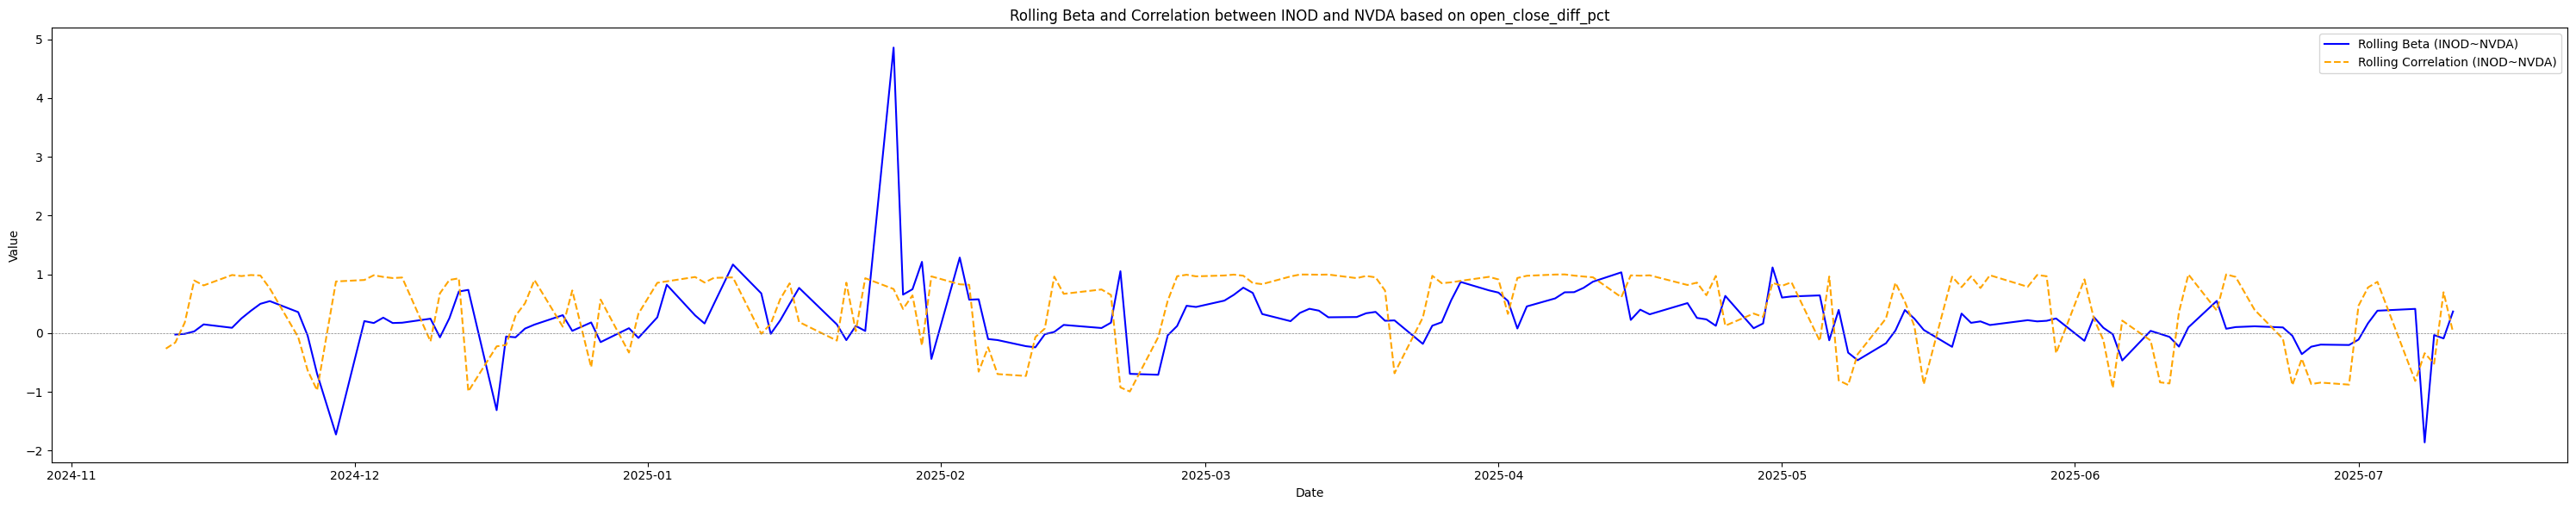

In [15]:
rolling_window = 3
selected_data['rolling_corr'] = selected_data['INOD_open_close_diff_pct'].rolling(rolling_window).corr(selected_data['NVDA_open_close_diff_pct']) 

def compute_rolling_beta(x, y, window):
    """
    Compute rolling beta between two series.
    """
    betas = []
    for i in range(len(x)):
        if i < window:
            betas.append(np.nan)  # Not enough data to compute beta
            continue
        y_window = y[i-window:i]
        x_window = x[i-window:i]
        x_window = sm.add_constant(x_window)  # Add constant for OLS regression
        model = sm.OLS(y_window, x_window).fit()
        betas.append(model.params[1]) # beta coefficient

    return betas

selected_data['rolling_beta'] = compute_rolling_beta(
    selected_data['INOD_open_close_diff_pct'], selected_data['NVDA_open_close_diff_pct'], window=rolling_window)

plt.figure(figsize=(30, 6))
plt.plot(selected_data['Date'], selected_data['rolling_beta'], label='Rolling Beta (INOD~NVDA)', color='blue')
plt.plot(selected_data['Date'], selected_data['rolling_corr'], label='Rolling Correlation (INOD~NVDA)', color='orange', linestyle='--')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.title('Rolling Beta and Correlation between INOD and NVDA based on open_close_diff_pct')
plt.xlabel('Date')
plt.ylabel('Value')
plt.tight_layout()
plt.show()

In [16]:
selected_data.columns

Index(['Date', 'INOD_open_close_diff_pct', 'INOD_high_low_diff_pct_frm_open',
       'NVDA_open_close_diff_pct', 'NVDA_volume_diff_frm_avg_pct',
       'NVDA_Close', 'NVDA_high_low_diff_pct_frm_open', 'INOD_pct_z',
       'NVDA_pct_z', 'rolling_corr', 'rolling_beta'],
      dtype='object')

In [17]:
vol_corr = selected_data['INOD_high_low_diff_pct_frm_open'].corr(selected_data['NVDA_high_low_diff_pct_frm_open'])
print(f"Correlation between INOD and NVDA High-Low Percentage Differences: {vol_corr:.4f}")
print(f'Average correlation between INOD and NVDA High-Low Percentage Differences: {selected_data["rolling_corr"].abs().mean():.4f}')
print(f'Average Beta between INOD and NVDA High-Low Percentage Differences: {selected_data["rolling_beta"].abs().mean():.4f}')

Correlation between INOD and NVDA High-Low Percentage Differences: 0.3496
Average correlation between INOD and NVDA High-Low Percentage Differences: 0.6937
Average Beta between INOD and NVDA High-Low Percentage Differences: 0.3850


In [18]:
test_df = combined_df[['INOD_open_close_diff_pct', 'NVDA_volume_diff_frm_avg_pct', 'INOD_volume_diff_frm_avg_pct']]
max_lag = 5

print("\nGranger Causality Test Results: Does NVDA Volume Predict INOD Price Movement?")
grangercausalitytests(
    test_df[['INOD_open_close_diff_pct', 'NVDA_volume_diff_frm_avg_pct']],
    maxlag=max_lag,
)


Granger Causality Test Results: Does NVDA Volume Predict INOD Price Movement?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1820  , p=0.6700  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1842  , p=0.6678  , df=1
likelihood ratio test: chi2=0.1842  , p=0.6678  , df=1
parameter F test:         F=0.1820  , p=0.6700  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1378  , p=0.8713  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.2812  , p=0.8688  , df=2
likelihood ratio test: chi2=0.2811  , p=0.8689  , df=2
parameter F test:         F=0.1378  , p=0.8713  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2279  , p=0.8769  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=0.7036  , p=0.8724  , df=3
likelihood ratio test: chi2=0.7026  , p=0.8726  , df=3
parameter F test:         F=0.2279  , p=0.8769  , df_denom=241, df_num=3

Granger Causal

{np.int64(1): ({'ssr_ftest': (np.float64(0.18202228918512645),
    np.float64(0.6700126578055796),
    np.float64(247.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(0.1842330862197636),
    np.float64(0.6677603510284145),
    np.int64(1)),
   'lrtest': (np.float64(0.18416523589144163),
    np.float64(0.6678178711582788),
    np.int64(1)),
   'params_ftest': (np.float64(0.18202228918510488),
    np.float64(0.6700126578055796),
    np.float64(247.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(0.13779856374377009),
    np.float64(0.8713419357579084),
    np.float64(244.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(0.2812446096081865),
    np.float64(0.8688173978927821),
    np.int64(2)),
   'lrtest': (np.float64(0.28108589671705886),
    np.float64(0.8688863468890603),
    np.int64(2)),
   'params_ftest': (np.float64(0.13779856374380062),
    np.float64(0.8713419357578848),
    np.float64(244.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],


In [19]:
max_lag = 10

print("\nGranger Test: Does INOD Volume Predict INOD Price Movement?")
grangercausalitytests(
    test_df[['INOD_open_close_diff_pct', 'INOD_volume_diff_frm_avg_pct']], 
    maxlag=max_lag
)


Granger Test: Does INOD Volume Predict INOD Price Movement?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1395  , p=0.7091  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1412  , p=0.7071  , df=1
likelihood ratio test: chi2=0.1411  , p=0.7072  , df=1
parameter F test:         F=0.1395  , p=0.7091  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7789  , p=0.4600  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.5898  , p=0.4516  , df=2
likelihood ratio test: chi2=1.5847  , p=0.4528  , df=2
parameter F test:         F=0.7789  , p=0.4600  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4469  , p=0.7197  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=1.3796  , p=0.7103  , df=3
likelihood ratio test: chi2=1.3758  , p=0.7112  , df=3
parameter F test:         F=0.4469  , p=0.7197  , df_denom=241, df_num=3

Granger Causality
number of lags

{np.int64(1): ({'ssr_ftest': (np.float64(0.1394689776136576),
    np.float64(0.7091298179807417),
    np.float64(247.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(0.14116293280734574),
    np.float64(0.707127625965156),
    np.int64(1)),
   'lrtest': (np.float64(0.14112309385609478),
    np.float64(0.7071670480379668),
    np.int64(1)),
   'params_ftest': (np.float64(0.1394689776136445),
    np.float64(0.709129817980769),
    np.float64(247.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(0.7789148282932541),
    np.float64(0.46004137315658256),
    np.float64(244.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(1.5897523954509858),
    np.float64(0.4516371451674367),
    np.int64(2)),
   'lrtest': (np.float64(1.584698968219982),
    np.float64(0.4527797457957897),
    np.int64(2)),
   'params_ftest': (np.float64(0.7789148282932802),
    np.float64(0.4600413731565701),
    np.float64(244.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],
      

In [20]:
selected_data.columns

Index(['Date', 'INOD_open_close_diff_pct', 'INOD_high_low_diff_pct_frm_open',
       'NVDA_open_close_diff_pct', 'NVDA_volume_diff_frm_avg_pct',
       'NVDA_Close', 'NVDA_high_low_diff_pct_frm_open', 'INOD_pct_z',
       'NVDA_pct_z', 'rolling_corr', 'rolling_beta'],
      dtype='object')

In [21]:
for lag in range(1, 6):
    selected_data[f'NVDA_open_close_diff_pct_lag_{lag}'] = selected_data['NVDA_open_close_diff_pct'].shift(lag)
    selected_data[f'NVDA_volume_diff_frm_avg_pct_lag_{lag}'] = selected_data['NVDA_volume_diff_frm_avg_pct'].shift(lag)

selected_data.dropna(inplace=True)

In [22]:
for lag in range(1, 6):
    corr = selected_data['INOD_open_close_diff_pct'].corr(
        selected_data[f'NVDA_open_close_diff_pct_lag_{lag}']
    )
    print(f'Lag {lag} - Corr (NVDA % diff → INOD): {corr:.4f}')

Lag 1 - Corr (NVDA % diff → INOD): -0.1798
Lag 2 - Corr (NVDA % diff → INOD): 0.1242
Lag 3 - Corr (NVDA % diff → INOD): 0.0274
Lag 4 - Corr (NVDA % diff → INOD): -0.0263
Lag 5 - Corr (NVDA % diff → INOD): -0.0457


The Lag here is still too big, we need something more granular

In [23]:
import sys
from pathlib import Path
# Resolve the project root from the notebook’s location
REPO_ROOT = Path.cwd().parents[0]  # assumes you're inside /Hitherto/notebooks/
SCRIPT_PATH = REPO_ROOT / "scripts"
sys.path.append(str(SCRIPT_PATH))
from intradaydata import update_intraday_csv

update_intraday_csv("NVDA")
update_intraday_csv("INOD")
update_intraday_csv("MRVL")

intraday_nvd = pd.read_csv('..\\raw_data\\intraday\\intraday_NVDA.csv')
intraday_mrvl = pd.read_csv('..\\raw_data\\intraday\\intraday_MRVL.csv')
intraday_inod = pd.read_csv('..\\raw_data\\intraday\\intraday_INOD.csv')

intraday_nvd.head()

Fetching NVDA from 2025-07-19 to 2025-07-27...


$NVDA: possibly delisted; no price data found  (1m 2025-07-19 -> 2025-07-27)


No new data returned for NVDA.
Fetching INOD from 2025-07-19 to 2025-07-27...


$INOD: possibly delisted; no price data found  (1m 2025-07-19 -> 2025-07-27)
$MRVL: possibly delisted; no price data found  (1m 2025-07-19 -> 2025-07-27)


No new data returned for INOD.
Fetching MRVL from 2025-07-19 to 2025-07-27...
No new data returned for MRVL.


,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2025-06-23 09:30:00-04:00,143.429993,143.429993,143.429993,143.429993,9728623,0.0,0.0
1,2025-06-23 09:31:00-04:00,143.440002,143.500000,142.800003,142.860001,1051819,0.0,0.0
2,2025-06-23 09:32:00-04:00,142.839996,142.990005,142.419998,142.919998,1041728,0.0,0.0
3,2025-06-23 09:33:00-04:00,142.890305,143.110001,142.320007,142.735001,1136112,0.0,0.0
4,2025-06-23 09:34:00-04:00,142.720001,142.735001,142.380005,142.479996,699507,0.0,0.0


In [24]:
import datetime as dt
print(intraday_nvd.head(2))
print(intraday_nvd.dtypes)

def cleanup(df):
    """
    Convert 'Datetime' to proper datetime format and extract temporal features.
    Optimizes column types for efficient time-based analysis.
    """
    df['Datetime'] = pd.to_datetime(df['Datetime'], dayfirst=False)

    # Extract temporal components
    df['Date'] = df['Datetime'].dt.date
    df['Time'] = df['Datetime'].dt.time
    df['Hour'] = df['Datetime'].dt.hour
    df['Minute'] = df['Datetime'].dt.minute
    df['Weekday'] = df['Datetime'].dt.day_name()

    # Drop unused or redundant columns
    df = df.drop(columns=['Datetime', 'Dividends', 'Stock Splits'], errors='ignore')

    # Optimize types
    df['Date'] = pd.to_datetime(df['Date'])  # promote from object to datetime64
    df['Weekday'] = pd.Categorical(
        df['Weekday'],
        categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
        ordered=True
    )

    return df

intraday_nvd = cleanup(intraday_nvd)
intraday_inod = cleanup(intraday_inod)
intraday_mrvl = cleanup(intraday_mrvl)

                    Datetime        Open        High         Low       Close  \
0  2025-06-23 09:30:00-04:00  143.429993  143.429993  143.429993  143.429993   
1  2025-06-23 09:31:00-04:00  143.440002  143.500000  142.800003  142.860001   

    Volume  Dividends  Stock Splits  
0  9728623        0.0           0.0  
1  1051819        0.0           0.0  
Datetime         object
Open            float64
High            float64
Low             float64
Close           float64
Volume            int64
Dividends       float64
Stock Splits    float64
dtype: object


In [25]:
def feature_selection(df: pd.DataFrame, stock_name: str) -> pd.DataFrame:
    """
    Enhances a stock DataFrame with derived analytical features:
    - Open-Close deltas (absolute and percent)
    - High-Low spreads (absolute and percent from Open/Close)
    - Volume deviation from average (absolute and percent)
    - Stock identifier label
    - Ordered columns
    """
    df = df.copy()  # avoid modifying original

    # Open-Close dynamics
    df['open_close_diff'] = df['Open'] - df['Close']
    df['open_close_diff_pct'] = (df['Close'] - df['Open']) / df['Open']

    # High-Low range
    df['high_low_diff'] = df['High'] - df['Low']
    df['high_low_diff_pct_frm_close'] = df['high_low_diff'] / (df['Close'] + 1e-6)
    df['high_low_diff_pct_frm_close'] = df['high_low_diff'] / df['Close']

    # Volume activity relative to average
    volume_avg = df['Volume'].mean()
    df['volume_diff_frm_avg'] = df['Volume'] - volume_avg
    df['volume_diff_frm_avg_pct'] = df['volume_diff_frm_avg'] / volume_avg

    # Tag the stock
    df['stock'] = stock_name

    # Reorder columns for coherence
    desired_order = [
        'Date',
        'Open', 'Close', 'open_close_diff', 'open_close_diff_pct',
        'High', 'Low', 'high_low_diff', 'high_low_diff_pct_frm_open', 'high_low_diff_pct_frm_close',
        'Volume', 'volume_diff_frm_avg', 'volume_diff_frm_avg_pct',
        'stock'
    ]
    
    # Gracefully reorder only if all desired columns exist
    existing_order = [col for col in desired_order if col in df.columns]
    df = df[existing_order + [col for col in df.columns if col not in existing_order]]
    def prefix_columns(df):
        stock_code = df['stock'].iloc[0] if 'stock' in df.columns else 'Unknown'
        df = df.copy()
        df = df.drop(columns=['stock'])  # remove redundant stock column
        df.columns = [f"{stock_code}_{col}" if col != 'Date' else 'Date' for col in df.columns]
        return df

    df = prefix_columns(df)
    return df

intraday_nvd = feature_selection(intraday_nvd, 'NVDA')
intraday_inod = feature_selection(intraday_inod, 'INOD')
intraday_mrvl = feature_selection(intraday_mrvl, 'MRVL')

In [26]:
print(intraday_nvd.columns)
print(intraday_inod.columns)
print(intraday_mrvl.columns)

Index(['Date', 'NVDA_Open', 'NVDA_Close', 'NVDA_open_close_diff',
       'NVDA_open_close_diff_pct', 'NVDA_High', 'NVDA_Low',
       'NVDA_high_low_diff', 'NVDA_high_low_diff_pct_frm_close', 'NVDA_Volume',
       'NVDA_volume_diff_frm_avg', 'NVDA_volume_diff_frm_avg_pct', 'NVDA_Time',
       'NVDA_Hour', 'NVDA_Minute', 'NVDA_Weekday'],
      dtype='object')
Index(['Date', 'INOD_Open', 'INOD_Close', 'INOD_open_close_diff',
       'INOD_open_close_diff_pct', 'INOD_High', 'INOD_Low',
       'INOD_high_low_diff', 'INOD_high_low_diff_pct_frm_close', 'INOD_Volume',
       'INOD_volume_diff_frm_avg', 'INOD_volume_diff_frm_avg_pct', 'INOD_Time',
       'INOD_Hour', 'INOD_Minute', 'INOD_Weekday'],
      dtype='object')
Index(['Date', 'MRVL_Open', 'MRVL_Close', 'MRVL_open_close_diff',
       'MRVL_open_close_diff_pct', 'MRVL_High', 'MRVL_Low',
       'MRVL_high_low_diff', 'MRVL_high_low_diff_pct_frm_close', 'MRVL_Volume',
       'MRVL_volume_diff_frm_avg', 'MRVL_volume_diff_frm_avg_pct', 'MRVL_T

In [27]:
def standardize_time_columns(df, ticker):
    return df.rename(columns={
        f'{ticker}_Hour': 'Hour',
        f'{ticker}_Minute': 'Minute',
        f'{ticker}_Time': 'Time',
        f'{ticker}_Weekday': 'Weekday'
    })

# Apply to each DataFrame
intraday_nvd = standardize_time_columns(intraday_nvd, 'NVDA')
intraday_inod = standardize_time_columns(intraday_inod, 'INOD')
intraday_mrvl = standardize_time_columns(intraday_mrvl, 'MRVL')

In [28]:
# Merge all three on the full temporal key set
intraday_combined_df = (
    intraday_nvd
    .merge(intraday_inod, on=['Date', 'Time', 'Hour', 'Minute', 'Weekday'], how='outer')
    .merge(intraday_mrvl, on=['Date', 'Time', 'Hour', 'Minute', 'Weekday'], how='outer')
)

In [29]:
intraday_combined_df.columns


desired_order = [
    'Date', 'Time', 'Hour', 'Minute', 'Weekday',

    # NVDA
    'NVDA_Open', 'NVDA_Close', 'NVDA_open_close_diff', 'NVDA_open_close_diff_pct',
    'NVDA_High', 'NVDA_Low', 'NVDA_high_low_diff', 'NVDA_high_low_diff_pct_frm_close',
    'NVDA_Volume', 'NVDA_volume_diff_frm_avg', 'NVDA_volume_diff_frm_avg_pct',

    # INOD
    'INOD_Open', 'INOD_Close', 'INOD_open_close_diff', 'INOD_open_close_diff_pct',
    'INOD_High', 'INOD_Low', 'INOD_high_low_diff', 'INOD_high_low_diff_pct_frm_close',
    'INOD_Volume', 'INOD_volume_diff_frm_avg', 'INOD_volume_diff_frm_avg_pct',

    # MRVL
    'MRVL_Open', 'MRVL_Close', 'MRVL_open_close_diff', 'MRVL_open_close_diff_pct',
    'MRVL_High', 'MRVL_Low', 'MRVL_high_low_diff', 'MRVL_high_low_diff_pct_frm_close',
    'MRVL_Volume', 'MRVL_volume_diff_frm_avg', 'MRVL_volume_diff_frm_avg_pct'
]

existing_order = [col for col in desired_order if col in intraday_combined_df.columns]
intraday_combined_df = intraday_combined_df[existing_order + [col for col in intraday_combined_df.columns if col not in existing_order]]


intraday_combined_df.columns

Index(['Date', 'Time', 'Hour', 'Minute', 'Weekday', 'NVDA_Open', 'NVDA_Close',
       'NVDA_open_close_diff', 'NVDA_open_close_diff_pct', 'NVDA_High',
       'NVDA_Low', 'NVDA_high_low_diff', 'NVDA_high_low_diff_pct_frm_close',
       'NVDA_Volume', 'NVDA_volume_diff_frm_avg',
       'NVDA_volume_diff_frm_avg_pct', 'INOD_Open', 'INOD_Close',
       'INOD_open_close_diff', 'INOD_open_close_diff_pct', 'INOD_High',
       'INOD_Low', 'INOD_high_low_diff', 'INOD_high_low_diff_pct_frm_close',
       'INOD_Volume', 'INOD_volume_diff_frm_avg',
       'INOD_volume_diff_frm_avg_pct', 'MRVL_Open', 'MRVL_Close',
       'MRVL_open_close_diff', 'MRVL_open_close_diff_pct', 'MRVL_High',
       'MRVL_Low', 'MRVL_high_low_diff', 'MRVL_high_low_diff_pct_frm_close',
       'MRVL_Volume', 'MRVL_volume_diff_frm_avg',
       'MRVL_volume_diff_frm_avg_pct'],
      dtype='object')

In [33]:
intraday_combined_df.isna().sum()

intraday_combined_df = intraday_combined_df.dropna(axis=0)

Simple A/B testing
Goal: Does INOD’s mean return change depending on NVDA’s volume intensity?

In [34]:
import scipy.stats as stats
# Create high vs low volume groups based on 50th percentile
threshold = intraday_combined_df['NVDA_volume_diff_frm_avg_pct'].median()

group_high = intraday_combined_df[intraday_combined_df['NVDA_volume_diff_frm_avg_pct'] > threshold]['INOD_open_close_diff_pct']
group_low = intraday_combined_df[intraday_combined_df['NVDA_volume_diff_frm_avg_pct'] <= threshold]['INOD_open_close_diff_pct']

# Perform t-test
t_stat, p_val = stats.ttest_ind(group_high, group_low, equal_var=False)

print(f"A/B Test — INOD Return under High vs Low NVDA Volume")
print(f"Mean Return (High Volume): {group_high.mean():.4f}")
print(f"Mean Return (Low Volume):  {group_low.mean():.4f}")
print(f"T-Statistic: {t_stat:.4f}, P-Value: {p_val:.4f}")


A/B Test — INOD Return under High vs Low NVDA Volume
Mean Return (High Volume): -0.0000
Mean Return (Low Volume):  0.0000
T-Statistic: -0.9252, P-Value: 0.3549


From the result and given P-Value we can conclude that this is statistically insignificant. Therefore NVDA volume reliably affects INOD returns—at least not in that configuration.

Adjusted R²
Goal: How much of INOD’s return can be explained by NVDA volume + price changes?

In [35]:
X = intraday_combined_df[['NVDA_open_close_diff_pct', 'NVDA_volume_diff_frm_avg_pct']]
y = intraday_combined_df['INOD_open_close_diff_pct']

X = sm.add_constant(X)  # adds the intercept
model = sm.OLS(y, X).fit()

print(model.summary())

                               OLS Regression Results                               
Dep. Variable:     INOD_open_close_diff_pct   R-squared:                       0.036
Model:                                  OLS   Adj. R-squared:                  0.036
Method:                       Least Squares   F-statistic:                     128.7
Date:                      Mon, 21 Jul 2025   Prob (F-statistic):           1.39e-55
Time:                              14:05:31   Log-Likelihood:                 32236.
No. Observations:                      6893   AIC:                        -6.447e+04
Df Residuals:                          6890   BIC:                        -6.445e+04
Df Model:                                 2                                         
Covariance Type:                  nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

Only 3.6% of the variation in INOD’s returns is explained by the model.
->This is very low, implying that while NVDA’s movement has some effect, it barely scratches the surface of what moves INOD intraday.

Both predictors are statistically significant, meaning they have non-zero impact on INOD’s return.

 A 1% move in NVDA correlates with a ~0.60% move in INOD on average.

A 100% increase in NVDA volume from average would push INOD return by 0.008%—tiny, but measurable.

The overall model is highly significant; the predictors together are meaningful in some form.

Ultimately, this model statistically confirms that INOD does move with NVDA—both in price and, faintly, in volume.
But in practical terms, the effect is real but weak, and most of INOD’s behavior remains unexplained.

In [36]:
A = intraday_combined_df['INOD_open_close_diff_pct'] > 0
B = intraday_combined_df['NVDA_volume_diff_frm_avg_pct'] > 0

P_A = A.mean()
P_B = B.mean()
P_A_and_B = (A & B).mean()
P_A_given_B = P_A_and_B / P_B

# Addition Rule (for non-mutually exclusive)
P_A_or_B = P_A + P_B - P_A_and_B

print(f"P(INOD↑) = {P_A:.4f}")
print(f"P(NVDA High Volume) = {P_B:.4f}")
print(f"P(INOD↑ | NVDA High Volume) = {P_A_given_B:.4f}")
print(f"P(INOD↑ or NVDA High Volume) = {P_A_or_B:.4f}")


P(INOD↑) = 0.4451
P(NVDA High Volume) = 0.3061
P(INOD↑ | NVDA High Volume) = 0.4526
P(INOD↑ or NVDA High Volume) = 0.6127


The significant information of this test is the first in P(INOD *going up) given this condition of 0.4451, the stock move in surge of extreme heights.